In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.ndimage import gaussian_filter1d

np.random.seed(52)

# Генерация синтетического сигнала
def generate_signal(seq_length=1000):
    time = np.linspace(0, seq_length, seq_length)

    # Основной синусоидальный сигнал
    base_frequency = 1
    signal = np.sin(2 * np.pi * base_frequency * time / (5 * seq_length))

    # Добавление гармоник
    for A, f_mult in ((0.5, 3), (0.3, 5)):
        harmonics = A * np.sin(2 * np.pi * (base_frequency * f_mult) * time / (6 * seq_length))
        signal += harmonics
    
    # # Добавление импульсов
    # impulses = []
    # for index in range(0, 1000, 50): 
    #     impulses.append(index)
    #     signal[index] += np.random.uniform(7, 10)

    # Добавление случайных импульсов
    impulses = []
    for _ in range(40): 
        impulse_position = np.random.randint(0, seq_length)
        impulses.append(impulse_position)
        signal[impulse_position] += np.random.uniform(7, 10)

    # Добавление шума
    noise = np.random.normal(0, 0.5, seq_length)
    signal += noise

    return smoothing(signal), impulses, signal

# Функция сглаживания
def smoothing(data, sigma=1):
    return gaussian_filter1d(data, sigma=sigma)

# Подготовка данных для обучения
def prepare_data(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        y.append(data[i + time_step])
    return np.array(X), np.array(y)

def train_model(X_train, y_train, epochs=50, batch_size=16):
    # Создание модели
    model = Sequential()
    model.add(Input(shape=(time_step, 1)))
    model.add(LSTM(50, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    # Компиляция модель
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Обучение модели
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    return model

# Параметры
sequence_length = 1000
time_step = 20
epochs = 50
batch_size = 16

# Генерация и нормализация данных
data, impulses, signal = generate_signal(sequence_length)
data = data.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Подготовка последовательностей
X, y = prepare_data(scaled_data, time_step)

# Разделение на обучающую и тестовую выборки
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Изменение формы входных данных для RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Обучение модели
model = train_model(X_train, y_train, epochs, batch_size)

# Прогнозирование
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# Оценка модели
mse = mean_squared_error(data[time_step + train_size:], predicted)
mae = mean_absolute_error(data[time_step + train_size:], predicted)

print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0446
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0207
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0290
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085
Epoch 16/50
49/49 ━

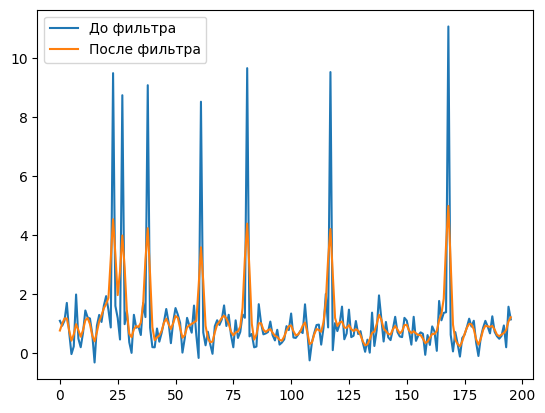

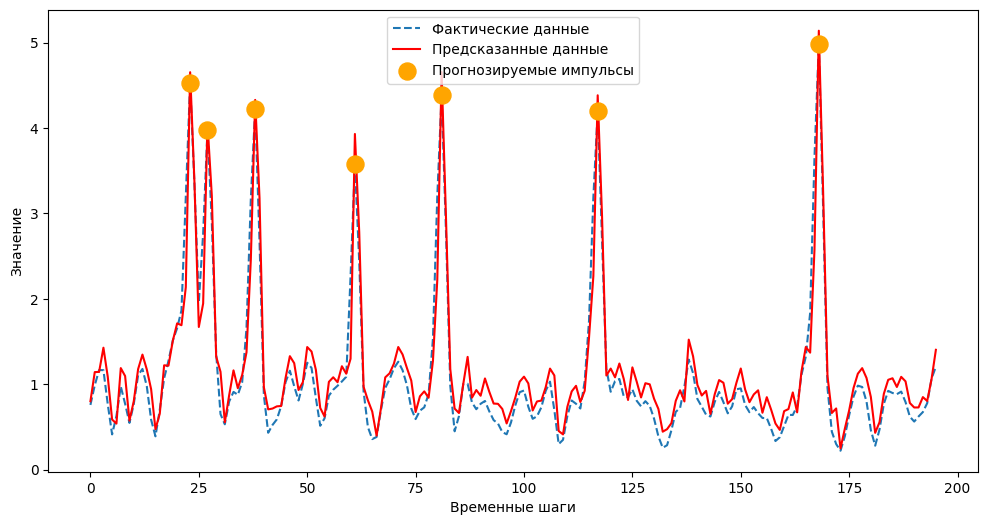

In [ ]:
# Визуализация входных данных
plt.plot(signal[time_step + train_size:], label='До фильтра')
plt.plot(data[time_step + train_size:], label='После фильтра')
plt.legend()
plt.show()

# Визуализация результатов
k, j = zip(*[(i - train_size - time_step, data[i]) for i in impulses if i >= (time_step + train_size)])

plt.figure(figsize=(12, 6))
plt.plot(data[time_step + train_size:], label='Фактические данные', linestyle='--')
plt.plot(predicted, label='Предсказанные данные', color='red')
plt.scatter(k, j, color='orange', s=150, label='Прогнозируемые импульсы', zorder=3)
plt.xlabel('Временные шаги')
plt.ylabel('Значение')
plt.legend()
plt.show()